# Projet 3 - Sparsité, estimation et sélection de variables

In [8]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

## Exercice 1

On simule ici n variables aléatoires suivant le modèle de suite gaussienne soit:
$$y_i=a*\eta_j +\xi_j \text{ avec:}$$
$$j=1,...,d ,$$
$$\eta_j \in \normalsize \{ 0,1 \normalsize \},$$
$$\text{a} \in \normalsize \{ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 \normalsize \},$$
$$\text{et }  \xi_j \sim N[0,1].$$
$$ \text{aussi, } \eta_i \text{ est tel que} \sum_{j=1}^d \eta_j= [d^{1-\beta}] $$ 
$$ \text{enfin, } \theta^{\star}_{j} = a * \eta_{j}$$ 
$$\text{puisque } \eta_{j} \in \normalsize \{0, 1 \normalsize \}, \text{ le vecteur } \theta^{\star}_{j} \text{ est un vecteur sparse}$$

On cherche ainsi à déterminer le vecteur sparse theta étoile à partir de différents estimateurs par seuillage:

1)Estimateur fort:
$$\hat{\theta}_j^H = y_i\mathbb{1}(|y_i| > \tau) $$

2) Estimateur faible:
$$\hat{\theta}_j^S = y_i\mathbb{1}(1-\frac{\tau}{|y_i|})_+ $$

3) Non Negative Garrotte:
$$\hat{\theta}_j^{NG} = y_i\mathbb{1}(1-\frac{\tau^2}{|y_i|^2})_+ $$

In [9]:
d = 50
beta = 0.3
tau = np.sqrt(2 * np.log(d))

def y(a, eta, ksi):
    return a * eta + ksi

def theta_chap_H(y, tau):
    return np.array(y * (np.abs(y) > tau * 1))

def theta_chap_S(y, tau):
    s = np.array(1 - tau/np.abs(y))
    #s[s < 0] = 0
    s = np.where(s < 0, 0, s)
    s = y * s
    return s

def theta_chap_NG(y, tau):
    ng = np.array(1 - np.power(tau, 2)/np.power(y, 2))
    #ng[ng < 0] = 0
    ng = np.where(ng < 0, 0, ng)
    ng = y * ng
    return ng

#### 1) On trace dans 1er temps, le graphe des 3 estimateurs avec un y variant entre -10 et 10

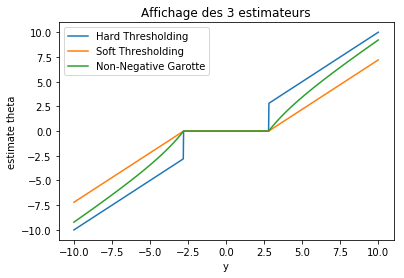

In [10]:
space = pd.Series(np.linspace(-10, 10, 1000))
theta_chap_H_graph = theta_chap_H(space, tau)
theta_chap_S_graph = theta_chap_S(space, tau)
theta_chap_NG_graph = theta_chap_NG(space, tau)

# Affichage des 3 graphes
plt.figure()
plt.title("Affichage des 3 estimateurs")
plt.xlabel("y")
plt.ylabel("estimate theta")
plt.plot(np.linspace(-10, 10, 1000), theta_chap_H_graph)
plt.plot(np.linspace(-10, 10, 1000), theta_chap_S_graph)
plt.plot(np.linspace(-10, 10, 1000), theta_chap_NG_graph)
plt.legend(["Hard Thresholding",
           "Soft Thresholding",
           "Non-Negative Garotte"])
plt.show()

On vérifie bien qu'autour de 0, les valeurs retournées sont nulles : c'est l'effet recherché lors de la construction d'un estimateur sparse.

#### 2) Risque Quadratique des estimateurs.
On rappelle:
$$R(\hat{\theta},a)=||\hat{\theta}-\theta^*||_2^2 $$
On a les données suivantes pour l'application numérique :
$$d = 50$$
$$\beta = 0.3$$

Afin de calculer le risque des estimateurs, nous allons simuler 50 observations de y, de la facon suivante :
 * Caclul du nombre de coordonnées non null du vecteur eta. Il est donné par la formule : 
 $$\sum_{j=1}^{50} \eta_j= 50^{1-0.3} = 15 $$ 
 * Simulation du vecteur eta, de manière aléatoire, et de facon à ce qu'il y ait exactement 15 coordonées de eta ayant pour valeur 1, les autres ayant pour valeur 0
 * Multiplication du vecteur eta par un scalaire a donné
 * Simulation d'un vecteur epsilon, dont les coordonnées suivent des lois normales centrées réduites
 * Somme des vecteur a*eta et epsilon : on obtient le vecteur y simulé
 * Afin de distinguer la partie bruitée (aléatoire) de Y, et sa partie déterministe, on renvoi le vecteur Y simulé, aiinsi que le vecteur a * eta, le bruit étant évidemment obtenu par la soustraction du premier par le second

a) Définition de la fonction de simulation de Y, et de la fonction de risque quadratique

In [11]:
def simul_y(d, beta, a):
    # eta = {0, 1}
    # Compute the sum of eta to get number of positive eta
    sum_eta = int(np.power(d, 1-beta))
    ksi = []
    Y = []
    theta_star = []
    # Initialize the etas vector (d,1) with only zeros
    eta = np.repeat(0, d)
    # Simulation eta vector
    # fill etas vector with ones, in order to have exactly sum_eta "1" and (d - sum_eta) "0"
    for i in range(1, sum_eta + 1):
        one_allocated = False
        while not one_allocated:            
            rnd = int(np.random.random() * d)
            one_allocated = (eta[rnd] == 0)
            eta[rnd] = 1
    # Simulating Y
    for j in range(0, d):
        ksi.append(np.random.normal(0, 1, 1)[0])
        Y.append(a * eta[j] + ksi[j])
        theta_star.append(a * eta[j])
    
    return pd.Series(Y), pd.Series(theta_star)

def quad_risk(Y, theta_star, theta_chap_func, tau):
    empirical_risk = 0
    for j in range(0, len(Y)):
        empirical_risk += np.power(theta_chap_func(Y[j], tau) - theta_star[j], 2)
    
    return empirical_risk

b) Calcul du risque quadratique, pour a variant de 1 à 10, et pour les 3 estimateurs par seuillage considérés.

Puisque le vecteur y est simulé, le risque est en réalité un risque quadratique empirique. Afin d'obtenir la "vrai" valeur du risque quadratique, pour chaque couple (a, estimateur par seuillage), on réitère la simulation nb_simul fois (la loi des grands nombres permettant de dire que ce que nous obtenons est la "vrai" valeur du risque)

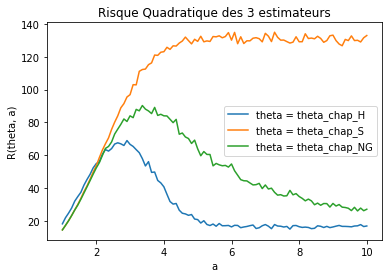

In [12]:
estimators = [theta_chap_H, theta_chap_S, theta_chap_NG]
a_list = np.linspace(1, 10, 100)
nb_simul = 100

all_estimators_graphs = {}
for estimator in estimators:
    estimator_graph = []
    for a in a_list:
        quad_risk_result = 0
        for i_simul in range(1, nb_simul):
            Y, theta_star = simul_y(d, beta, a)
            quad_risk_result += quad_risk(Y, theta_star, estimator, tau)
        quad_risk_result /= nb_simul
        estimator_graph.append(quad_risk_result)
    all_estimators_graphs.update({estimator.__name__:
                                estimator_graph})

plt.figure()
plt.title("Risque Quadratique des 3 estimateurs")
plt.xlabel("a")
plt.ylabel("R(theta, a)")
legends = []
for estimator_name, estimator_graph in all_estimators_graphs.items():
    plt.plot(a_list, estimator_graph)
    legends.append("theta = " + estimator_name)
plt.legend(legends)
plt.show()

On observe que le risque quadratique tend vers 20 pour l'estimateur par seuillage dur et non-negative garrotte mais qu'il tend vers 130 pour l'estimateur par seuillage doux.

#### 3) Risque de Sélection de Variables des estimateurs
Ce risque s'exprime comme:
$$ R^{MS}(\hat{\theta},a)=\sum_{j=1}^M |\eta_j -\hat{\eta_j}| $$
$$\text{avec } \hat{\eta_j}=\mathbb{1}(|y_i| \geqslant \tau) $$
$$\text{et } \eta_j \in \normalsize \{ \normalsize 0,1 \} $$

Il représente le risque de définir une coordonnée de theta chapeau comme n'étant pas nulle, alors qu'elle l'est en réalité (dans theta étoile).
Ainsi, puisque c'est le vecteur eta chapeau (étoile) qui définit les coordonnée non-nulles de theta chapeau (étoile), le risque est calculé comme la somme des différences entre chaque coordonnées de theta étoile et theta chapeau.
    

In [13]:
def selection_var_risk(eta, eta_chap):
    sum_risk = 0
    for j in range(0, len(eta)):
        sum_risk += np.abs(eta[j] - eta_chap[j])

    return sum_risk

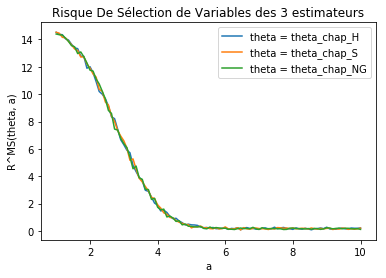

In [14]:
estimators = [theta_chap_H, theta_chap_S, theta_chap_NG]
a_list = np.linspace(1, 10, 100)
nb_simul = 100

all_risk_graph = {}
for estimator in estimators:
    risk_graph = []
    for a in a_list:
        selection_var_risk_result = 0
        for i_simul in range(1, nb_simul):
            Y, theta_star = simul_y(d, beta, a)
            eta = theta_star/a
            eta_chap = (np.abs(Y) >= tau) * 1
            selection_var_risk_result += selection_var_risk(eta, eta_chap)
        selection_var_risk_result /= nb_simul
        risk_graph.append(selection_var_risk_result)
    all_risk_graph.update({estimator.__name__:
                                risk_graph})

plt.figure()
plt.title("Risque De Sélection de Variables des 3 estimateurs")
plt.xlabel("a")
plt.ylabel("R^MS(theta, a)")
legends = []
for estimator_name, risk_graph in all_risk_graph.items():
    plt.plot(a_list, risk_graph)
    legends.append("theta = " + estimator_name)
plt.legend(legends)
plt.show()

On constate que le risque de sélection de variable tend vers 0 pour chaque estimateur.
Ainsi, en ce qui concerne la sélection de variables, les 3 estimateurs font aussi bien, et à partir de a = 5, ce risque est nul pour les 3 estimateurs.

#### Conclusion

Nous avons donc comparé, dans cette exercice, les propriétés de 3 estimateurs :
 * L'estimateur par seuilage doux
 * L'estimateur par seuillage dur
 * l'estimateur "non-negative garrotte"

Voici un tableau récapitulatif de nos résultats : 

|   Estimateur      | Risque Quadratique | Risque De séléction de variables |
|-------------------|--------------------|----------------------------------|
|   Seuillage doux  |      Mauvais       |              Bon                 |
|   Seuillage dur   |     Très Bon       |              Bon                 |
| Non-Neg Garrotte  |        Bon         |              Bon                 |

 * On observe que ces 3 estimateurs sont inégaux par rapport au risque quadratique : l'estimateur par seuillage doux présente le risque le plus fort, tandis que l'estimateur par seuillage dur présente le risque le plus faible, ou en tout cas convergeant le plus rapidement vers ce niveau (par rapport à "non-negative garrotte".
 
 * En revanche, ils présentent un même "meilleur" niveau de risque de sélection de variables (ce niveau étant nul par ailleurs), et une vitesse de convergence identique.

On peut donc conclure à priori, que l'estimateur par seuillage dur est le meilleur parmi ces 3 estimateurs, dans la mesure où il présente un risque quadratique généralement plus faible, associé à un risque de sélection de variable égal aux autres estimateurs, et de valeur nulle.

## Exercice 2

Dans cette exercice on s'interesse à la détection de rupture.
On considère, comme dans l'exercice précèdent, un modèle de Suites Gaussiennes.

La Matrice Theta etoile nous est donnée, et est de la forme :

| theta etoile|
|-------------|
|      3      |
|      3      |
|     ...     |
|      3      |
|      7      |
|      7      |
|     ...     |
|      7      |
|     1.5     |
|     1.5     |
|     ...     |
|     1.5     |
|      2      |
|      2      |
|     ...     |

Le vecteur n'est donc pas sparse, et l'on cherche à détecter les ruptures sur le vecteur theta etoile.
Que peut-on faire ?
 * Nous allons définir une vecteur delta, qui sera la différence entre les coefficients de theta etoile, obtenant ainsi un vecteur sparse.
 * Nous allons ensuite appliquer une estimation par seuillage dur sur les coordonnées de delta, obtenant ainsi le vecteur delta chapeau
 * Et ainsi trouver le vecteur J etoile, indiquant les indices où les coordonnées du vecteur delta ne sont pas nulles, et indiquant, par la même, les points de rupture sur theta etoile : ce sont les indices où delta chapeau est différent de 0.

In [15]:
d = 50
tau = np.sqrt(2*np.log(d))

theta_star = np.repeat(1, d)
theta_star[0:10] = np.repeat(3, 10)
theta_star[10:30] = np.repeat(7, 20)
theta_star[30:40] = np.repeat(1.5, 10)
theta_star[40:] = np.repeat(2, (d-40))

theta_star = pd.Series(theta_star)

### Simulation de Y et calcul du vecteur delta

In [16]:
epsilon = 1/np.sqrt(d)
y = theta_star + epsilon * np.random.normal(0, 1, d)
y.head()

0    2.783021
1    3.073928
2    2.824183
3    2.902715
4    3.018084
dtype: float64

Création de la matrice Delta

Celle ci est construite comme suit:
$$\Delta_j^*=z_{j+1}-z_j $$

 * à partir du vecteur theta --> pas d'aléatoire

In [17]:
delta = theta_star - theta_star.shift(1)
delta = delta.dropna().reset_index(drop=True)
delta.head(11)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     4.0
10    0.0
dtype: float64

 * à partir du vecteur y --> theta + de l'aléatoire

In [18]:
y_delta = y - y.shift(1)
y_delta = y_delta.dropna().reset_index(drop=True)
y_delta.head(11)

0     0.290907
1    -0.249745
2     0.078532
3     0.115369
4     0.274495
5    -0.404199
6     0.313919
7    -0.185769
8    -0.115767
9     4.312389
10   -0.070362
dtype: float64

### Estimation de delta chapeau

$$\textbf{Seuillage Dur} $$

Pour estimer J*, vecteur des coordonnées non nulles de delta, on utilse les différents estimateurs de seuillage de l'exercie 1, sur delta_chapeau.

 * Estimation de J*

In [19]:
delta_chap = theta_chap_H(y_delta, tau)
J_star = np.where(delta_chap != 0)
J_star

(array([ 9, 29], dtype=int64),)

 * Risque Quadratique Estimé

In [20]:
est_quad_risk_H = quad_risk(y_delta, delta, theta_chap_H, tau)
print(est_quad_risk_H)

1.1056740482751921


$$\textbf{Seuillage Doux} $$

 * Estimation de J*

In [21]:
delta_chap = theta_chap_S(y_delta, tau)
J_star = np.where(delta_chap != 0)
J_star

(array([ 9, 29], dtype=int64),)

 * Risque Quadratique Estimé

In [22]:
est_quad_risk_S = quad_risk(y_delta, delta,theta_chap_S, tau)
print(est_quad_risk_S)


14.503087107569073


$$ \textbf{Non-Negative Garrotte}$$

 * Estimation de J*

In [23]:
delta_chap = theta_chap_NG(y_delta, tau)
J_star = np.where(delta_chap != 0)
J_star

(array([ 9, 29], dtype=int64),)

 * Risque Quadratique Estimé

In [24]:
est_quad_risk_NG = quad_risk(y_delta, delta,theta_chap_NG, tau)
print(est_quad_risk_NG)

4.683396150560334


$$\textbf{Résultat:} $$
On connais nos points de ruptures, et l'on souhaite voir si nos estimateurs les détectent.
Les points de rupture sont aux période 10, 30 et 40.
On constate que le vecteur J* calculé à partir des 3 estimateurs détecte bien les deux premières ruptures, mais aucun ne parviennent à détecter la dernière rupture.
Cela semble à priori logique dans la mesure où, dans les deux premières ruptures, le delta est supérieur ou égal à 4, alors que pour la 3ème et dernière rupture, le delta n'est que de 0.5 : ce pourrais vraisemblablement n'être que du bruit.

## Exercice 3

On s'interrese ici au cours de Bourse de Renault sur la période 2018. On sait que les révélations sur Carlos Ghosn ont eut un impact qui a fait chuter d'un coup le cours en bourse.
On veut savoir si nos estimateurs définis dans ce projet, sont capables de détecter cette rupture.
Nous allons ainsi reproduire la procédure de l'exercice 2, mais sur le cours de bourse de l'action Renault.

In [28]:
df = pd.read_excel(r"CoursRenault.xls")

close = df["clot"]
date=df["date"]


d = len(close)
tau = np.sqrt(5*np.log(d))
close.head()

0    85.23
1    84.88
2    83.92
3    83.51
4    84.41
Name: clot, dtype: float64

In [29]:
close_delta = close - close.shift(1)
close_delta = close_delta.dropna().reset_index(drop=True)

In [30]:
theta_chap = theta_chap_H(close_delta, tau)
J_star = np.where(theta_chap != 0)
print(J_star)
print(date[J_star[0]+1])

(array([ 79, 243], dtype=int64),)
80    2018-03-29
244   2018-11-19
Name: date, dtype: datetime64[ns]


On observe bien une rupture du cours de bourse au niveau de la 243ème valeur du Dataset (à la date du 19/11/2018) ce qui correspond au jour de sortie des révélations. L'autre point de ruputre du 29 mars correspond à une rumeur de fusion avec Nissan.